In [1]:
from fed.utils.pipeline import PairedFeatureBank, MMVAETrainer
from experiments.mmvae.mnist.model import (
    get_mnist_audio_encoder,
    get_mnist_image_encoder,
    _make_mlp
)
from experiments.mmvae.mnist.dataset import mmMNIST
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from reconstruct.mmvae import DecoupledMMVAE


from experiments.ssl.dataset import get_mnist_transform

import torchvision.transforms as T




device = 'cuda'
public_dataset_path = '/root/autodl-tmp/csv/mmMNIST_server.csv'
# public_dataset_path =  '/root/fedRec/clients/train/9.csv'

_, image_transform = get_mnist_transform()
image_transform = T.Compose(image_transform)
public_dataset = mmMNIST(public_dataset_path, with_label=True, image_transform=image_transform)

CKP_PATH = '/root/fedRec/ckp/components/66/mm_nega_gen_penalize_1.pt'
ckp = torch.load(CKP_PATH)

import torch.nn as nn
def get_proj_head(inplanes, hidden_dim, outplanes):
    return nn.Sequential(
        nn.Linear(inplanes, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, outplanes)
    )

from model.simclr import StandardPipeline

def get_extractor(mod):
    if mod == 'audio':
        backbone = get_mnist_audio_encoder()
    elif mod == 'image':
        backbone = get_mnist_image_encoder()
    return backbone

def make_mlp(inplanes, hidden_dim, out_dim, use_bn=False):
    if use_bn:
        return nn.Sequential(
            nn.Linear(inplanes, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    else:
        return nn.Sequential(
            nn.Linear(inplanes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

audio_backbone = get_extractor('audio').to(device)
audio_backbone.load_state_dict(ckp['audio'])

audio_backbone.eval()

audio_proj_head = get_proj_head(64, 256, 128).to(device)
audio_proj_head.load_state_dict(ckp['audio_proj_head'])

image_backbone = get_extractor('image').to(device)
image_backbone.load_state_dict(ckp['image'])

image_backbone.eval()

image_proj_head = get_proj_head(64, 256, 128).to(device)
image_proj_head.load_state_dict(ckp['image_proj_head'])


def get_rec_network(embed_dim=64, hidden_dim=128):
    return make_mlp(embed_dim, hidden_dim, embed_dim, use_bn=False)


def get_mmvae(embed_dim=64, hidden_dim=128, bottleneck_dim=32):
    criterion = nn.MSELoss()
    mmvae_config = {
        'encoders' : nn.ModuleDict({
            '0' : _make_mlp(embed_dim, hidden_dim, bottleneck_dim * 2, use_bn=True),
            '1' : _make_mlp(embed_dim, hidden_dim, bottleneck_dim * 2, use_bn=True)
        }).to(device),
        'decoders' : nn.ModuleDict({
            '0' : _make_mlp(bottleneck_dim, hidden_dim, embed_dim, use_bn=True),
            '1' : _make_mlp(bottleneck_dim, hidden_dim, embed_dim, use_bn=True)
        }).to(device),
        'latent_dim' : bottleneck_dim,
        'score_fns' : {'0' : criterion, '1' : criterion}
    }
    mmvae = DecoupledMMVAE(**mmvae_config)
    return mmvae

# load mmvae 
# mmvae = get_mmvae().to(device)
# mmvae.load_state_dict(ckp['mmvae'])

# mmvae.eval()


# get everything ready
# a2i = get_rec_network(64, 128).to(device)
# a2i.load_state_dict(ckp['a2i'])

# i2a = get_rec_network(64, 128).to(device)
# i2a.load_state_dict(ckp['i2a'])


# embed_dataset = PairedFeatureBank(
#         public_dataset,
#         (audio_backbone, image_backbone, ),
#         device
# )

FileNotFoundError: [Errno 2] No such file or directory: '/root/fedRec/ckp/components/66/mm_nega_gen_penalize_1.pt'

In [ ]:
from torch.utils.data import Dataset
class ThinDatasetWrapper(Dataset):
    def __init__(self,
                 base_dataset,
                 out_index):
        super().__init__()
        self.base_dataset = base_dataset
        self.out_index = out_index
    def __len__(self):
        return len(self.base_dataset)
    def __getitem__(self, idx):
        base_out = self.base_dataset[idx]
        return [base_out[i] for i in self.out_index]

wrapped_dataset = ThinDatasetWrapper(
                    base_dataset=public_dataset,
                    out_index=[0,1]
                )

# whole_audio = nn.Sequential(
#     audio_backbone, audio_proj_head
# ).to(device)

# whole_image = nn.Sequential(
#     image_backbone, image_proj_head
# ).to(device)


from reconstruct.mmvae.mmvae import _mod_ae

# audio_ae = _mod_ae(
#     mmvae.encoders['0'],
#     mmvae.decoders['0'],
#     32
# )

# image_ae = _mod_ae(
#     mmvae.encoders['1'],
#     mmvae.decoders['1'],
#     32
# )

# whole_audio = nn.Sequential(
#     audio_backbone,
#     audio_ae
# ).to(device)
# whole_image = nn.Sequential(
#     image_backbone,
#     image_ae
# ).to(device)


whole_audio = audio_backbone.to(device)
whole_image = image_backbone.to(device)

embed_dataset = PairedFeatureBank(
        wrapped_dataset,
        (whole_audio, whole_image, ),
        device,
        dataloader_config={'batch_size':32, 'shuffle':False},
)

    

In [2]:
import numpy as np
embed_label = []
for i in range(len(public_dataset)):
    embed_label.append(int(public_dataset[i][-1]))
embed_label = np.array(embed_label)
embed_label[100]

0

In [3]:
np.unique(np.array(embed_label))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
import numpy as np
def _to_numpy(t):
    return t.detach().contiguous().cpu().numpy()
np_audio_dataset = []
np_image_dataset = []
for idx in range(len(embed_dataset)):
    np_audio_dataset.append(
       _to_numpy(embed_dataset[idx][0])[:32]
    )
    np_image_dataset.append(
        _to_numpy(embed_dataset[idx][1])[:32]
    )
np_audio_dataset = np.array(np_audio_dataset)
np_image_dataset = np.array(np_image_dataset)
np_image_dataset.shape

# np.save('audio_features.npy', np_audio_dataset)
# np.save('image_feature.npy', np_image_dataset)

NameError: name 'embed_dataset' is not defined

In [6]:
np_audio_dataset[0]

array([-0.14684463,  0.07864901,  0.0371966 , -0.04160846,  0.0336996 ,
       -0.01829393,  0.03983907,  0.04422716,  0.00870413,  0.04160473,
       -0.172032  , -0.0985631 ,  0.00352615,  0.03474489, -0.06935377,
        0.10523367, -0.09861812, -0.07941288,  0.09737009,  0.09946048,
       -0.00129269,  0.01451132, -0.03222652, -0.04865691, -0.02480151,
       -0.14973836, -0.10624155,  0.09681458,  0.02227302, -0.11217283,
        0.02409052,  0.07963302,  0.08739645,  0.0515225 ,  0.14086543,
       -0.03074384,  0.09002356,  0.12188783, -0.07323778,  0.08408431,
       -0.00645731, -0.01078932, -0.05432891, -0.02134375,  0.06745705,
        0.00716452, -0.11255816, -0.00311052,  0.07532337, -0.04418093,
       -0.01503423, -0.08548035, -0.11339086, -0.04720231, -0.0945854 ,
        0.12257762,  0.07931153,  0.01734636, -0.04399594,  0.01536199,
       -0.02302885, -0.01653697, -0.14558682,  0.08184862], dtype=float32)

In [6]:
from fed.utils.pipeline import _TensorDatasetWrap
from torch.utils.data import DataLoader
# generate everything
mmvae.eval()

wrapped_audio_embed_ds = _TensorDatasetWrap(np_audio_dataset)
wrapped_audio_embed_dl = DataLoader(wrapped_audio_embed_ds, batch_size=32, shuffle=False)
generated_image = []
for x in wrapped_audio_embed_dl:
    x = x.to(device)
    generated_image.append(
       _to_numpy(mmvae.reconstruct({'0' : x})['1'])
    )
    
generated_image = np.concatenate(generated_image, axis=0)
generated_image.shape

(8000, 64)

In [7]:
drawn_audio_embed = []
for _ in range(80):
    drawn_audio_embed.append(
        _to_numpy(mmvae.generate(num_sample=100)['0'])
    )
drawn_audio_embed = np.concatenate(drawn_audio_embed, axis=0)
drawn_audio_embed.shape

(8000, 64)

In [7]:
# generate everything
mmvae.eval()

wrapped_image_embed_ds = _TensorDatasetWrap(np_image_dataset)
wrapped_image_embed_dl = DataLoader(wrapped_image_embed_ds, batch_size=32, shuffle=False)
generated_audio = []
for x in wrapped_image_embed_dl:
    x = x.to(device)
    generated_audio.append(
       _to_numpy(mmvae.reconstruct({'1' : x})['0'])
    )
    
generated_audio = np.concatenate(generated_audio, axis=0)
generated_audio.shape

(8000, 64)

In [ ]:
from sklearn.manifold import TSNE

# feature_bank = generated_audio

# feature_bank = np.concatenate(
#     [drawn_audio_embed, np_audio_dataset],
#     axis=0
# )
isotropic_norm = np.random.normal(0, 1, (8000, 64))
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np_audio_dataset)

plt.figure(figsize=(10, 10))
# for idx in range(20):
#     idcs = np.array(range(idx*800, (idx+1) * 800))
#     X = embeds[idcs, 0]
#     Y = embeds[idcs, 1]
#     plt.scatter(X, Y, label=int(idx / 10))
    
for idx in range(10):
    idcs = np.array(range(idx*800, (idx+1) * 800))
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
plt.legend()
plt.show()

In [11]:
np.mean(np_audio_dataset, axis=0)

array([-4.1459892e-03,  1.6713678e-03, -6.3234097e-03,  2.0154205e-03,
        8.1957478e-05, -1.7588073e-04, -3.3239720e-03, -1.8540666e-03,
        6.0152110e-05,  2.3422264e-03,  8.1159914e-04, -1.9419756e-04,
        1.8495466e-03, -6.9403142e-04, -1.7697776e-03,  4.4256475e-04,
        2.3721233e-03,  5.9974991e-04, -1.2229627e-03, -1.2690090e-03,
       -8.3339674e-04,  1.2855032e-03, -3.4502317e-04, -1.5611537e-03,
       -2.6732478e-03,  1.0498563e-03, -1.5015972e-03,  1.7159642e-03,
        1.9588685e-03,  1.2453625e-03, -1.4578582e-03,  2.6169112e-03,
        1.7963959e-01,  1.7925848e-01,  1.8117483e-01,  1.7710166e-01,
        1.7913765e-01,  1.7811330e-01,  1.7771789e-01,  1.7720023e-01,
        1.7927924e-01,  1.7815281e-01,  1.7607233e-01,  1.7508769e-01,
        1.7832159e-01,  1.8243369e-01,  1.7908452e-01,  1.8234296e-01,
        1.7833835e-01,  1.8191704e-01,  1.8088685e-01,  1.7720422e-01,
        1.7918879e-01,  1.7994401e-01,  1.7702624e-01,  1.7684864e-01,
      

In [16]:
np.diag(np.cov(np_audio_dataset.T))

array([0.00110972, 0.00070607, 0.00104128, 0.00059187, 0.00196636,
       0.00136482, 0.0005969 , 0.00065672, 0.00070707, 0.00076199,
       0.00103169, 0.00103547, 0.00081812, 0.00082094, 0.00175387,
       0.00097474, 0.00080223, 0.00071633, 0.00064705, 0.00096571,
       0.00116723, 0.00090382, 0.00231719, 0.00181125, 0.00163678,
       0.00096853, 0.00100865, 0.00123626, 0.00216426, 0.0007308 ,
       0.001528  , 0.00125205, 0.00141135, 0.00127092, 0.00114007,
       0.00481102, 0.00088787, 0.00160829, 0.00110558, 0.00210895,
       0.00072577, 0.00421917, 0.00098718, 0.00117614, 0.00213208,
       0.00099574, 0.00086917, 0.00102839, 0.0031085 , 0.00123747,
       0.00080125, 0.00077986, 0.00148795, 0.00182834, 0.00139849,
       0.00358313, 0.00448123, 0.00340326, 0.00275192, 0.00207432,
       0.0016134 , 0.00307655, 0.00288916, 0.00133403])

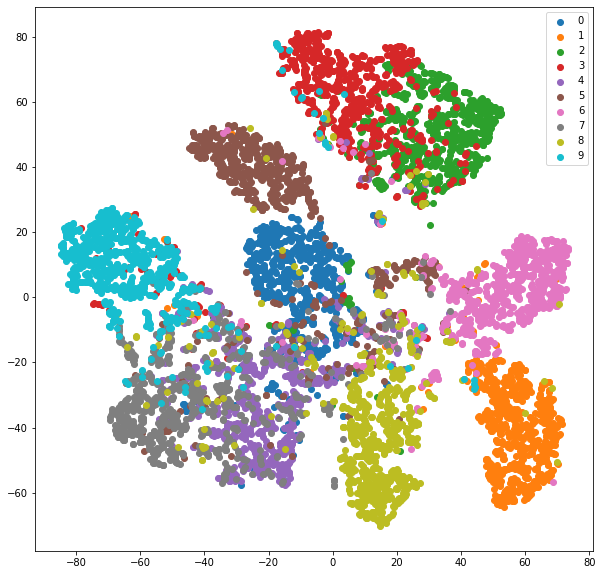

In [9]:
from sklearn.manifold import TSNE

# feature_bank = generated_audio

feature_bank = np.concatenate(
    [generated_audio, np_image_dataset], 
    axis=0
)
# print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(generated_image)

plt.figure(figsize=(10, 10))
# for idx in range(20):
#     idcs = np.array(range(idx*800, (idx+1) * 800))
#     X = embeds[idcs, 0]
#     Y = embeds[idcs, 1]
#     plt.scatter(X, Y, label=int(idx / 10))v
    
for idx in range(10):
    idcs = np.array(range(idx*800, (idx+1) * 800))
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
plt.legend()
plt.show()

(8000, 32)


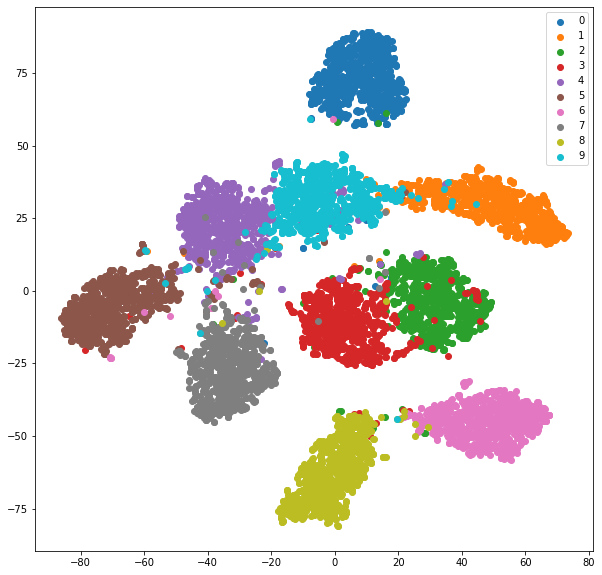

In [14]:
from sklearn.manifold import TSNE

feature_bank = np_audio_dataset
print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
for idx in range(10):
    idcs = np.where(embed_label == idx)
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
plt.legend()
plt.show()

(8000, 32)


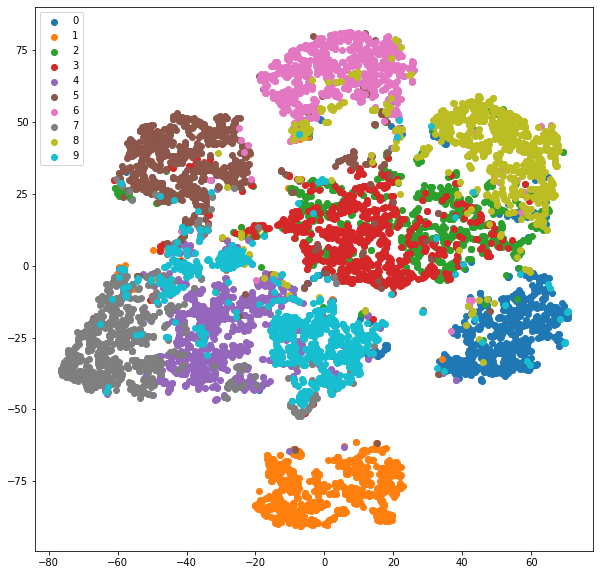

In [15]:
from sklearn.manifold import TSNE

feature_bank = np_image_dataset
print(feature_bank.shape)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
for idx in range(10):
    idcs = np.where(embed_label == idx)
    X = embeds[idcs, 0]
    Y = embeds[idcs, 1]
    plt.scatter(X, Y, label=idx)
plt.legend()
plt.show()

In [ ]:
#### check the reconstrutability of the learned embedding

from fed.utils.pipeline import _TensorDatasetWrap
from utils.train import linear_prob, vanilla_trainer

from torch.utils.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim

probe_set = _TensorDatasetWrap([np_audio_dataset, np_image_dataset])
probe_dl = DataLoader(probe_set, batch_size=64, shuffle=True)

criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

# priors = torch.tensor(centers).to(device)  # (num_center, latent_dim)


# labels = torch.tensor(labels).to(device)
# learn to reconstruct by learning the weight and prior
# input -> 64-dim embeddings   --> intermediate: $NUMBER CENTER prior

# prior_mapper = nn.Sequential(
#     nn.Linear(64, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
# ).to(device)

prior_mapper = nn.Sequential(
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
).to(device)

# prior_mapper.load_state_dict(ckp['a2i'])

# prior_mapper = nn.Linear(64, NUM_CENTER).to(device)

probe_optim = optim.Adam(prior_mapper.parameters(), lr=1e-3, weight_decay=1e-5)


# X = torch.tensor(np.random.randn(64, 5)).cuda()
# res = prior_mapper(X)


def prior_fwd(model, inputs):
    audio_x, image_x = inputs
    audio_x = audio_x.to(device)
    image_x = image_x.to(device)
    rec = model(image_x)
    loss = criterion(rec, audio_x)
    return loss

vanilla_trainer(
    prior_mapper, probe_dl,
    probe_optim, 
    criterion,
    35,
    device,
    unpack_and_forward=prior_fwd,
    save_path='prior_mapper.pt'
)


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
#### check the reconstrutability of the learned embedding
torch.set_printoptions(precision=4, sci_mode=False)

from fed.utils.pipeline import _TensorDatasetWrap
from utils.train import linear_prob, vanilla_trainer

from torch.utils.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim

probe_set = _TensorDatasetWrap([np_audio_dataset, np_image_dataset])
probe_dl = DataLoader(probe_set, batch_size=1, shuffle=False)

criterion = nn.MSELoss()
prior_mapper.eval()


def prior_fwd(model, inputs):
    audio_x, image_x = inputs
    audio_x = audio_x.to(device)
    image_x = image_x.to(device)
    rec = model(image_x)
    loss = criterion(rec, audio_x)
    print(rec[0][-10:])
    print(audio_x[0][-10:])
    print(loss)
    return loss

for i, inputs in enumerate(probe_dl):
    with torch.no_grad():
        loss = prior_fwd(prior_mapper, inputs)
    print(loss)
    if i == 0:
        break
    

In [ ]:
def to_numpy(t):
    return t.detach().contiguous().cpu().numpy()
# prior_mapper.eval()
import torch.nn.functional as F

audio, image = probe_set[10]

sample = audio
target = image
target = torch.tensor(target).unsqueeze(0).to(device)
sample = torch.tensor(sample).unsqueeze(0).to(device)


def norm(np_t):
    # wrap to torch tensor
    torch_t = torch.tensor(np_t).to(device)
    if len(torch_t.shape) == 1:
        return F.normalize(torch_t.unsqueeze(0), dim=-1).squeeze()
    else:
        return F.normalize(torch_t)
        
    

def get_converter():
    return nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
        ).to(device)

converter = get_converter()
converter.load_state_dict(ckp['a2i'])


# converter = prior_mapper
print('ground truth: \n', target)
rec = converter(sample)
print('reconstruct: \n', rec)
# print('normed: \n', F.normalize(rec)[0])

residual = criterion(target, rec)
print('residual', residual)

In [ ]:
# extractor clustering centers for iamge embeddings
kmeans_cluster = KMeans(n_clusters=8).fit(np_image_dataset)
priors = kmeans_cluster.cluster_centers_

In [ ]:
import numpy as np

def low_rank_approximate(x, n_component=0.1):
    n_sample, n_dim = x.shape
    if n_component <= 1:
        n_component = int(n_component * n_dim)
    u, sigma, vt = np.linalg.svd(x)
    truncated_sigma = np.diag(sigma[:n_component], 0)
    
    # approximating matrices
    u_prime = np.zeros((n_sample, n_component), x.dtype)
    u_prime[:,:] = u[:,:n_component]
    
    vt_prime = np.zeros((n_component, n_dim), x.dtype)
    vt_prime[:,:] = vt[:n_component, :]
    
    approximated_x = u_prime @ truncated_sigma @ vt_prime
    return approximated_x


In [ ]:
from sklearn.manifold import TSNE

feature_bank = np.concatenate(
    [np_audio_dataset, np_image_dataset],
    axis=0
)
print(feature_bank.shape)

labels = []
num_sample = 8000
for i in range(2):
    labels += [i for _ in range(num_sample)]
labels = np.array(labels)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
names = ['real_audio', 'real_image']
for idx, name in enumerate(names):
    indices = np.where(labels == idx)
    plt.scatter(embeds[indices, 0], embeds[indices, 1], label=f'{name}')
plt.legend()
plt.show()

In [ ]:
from fed.utils.pipeline import PriorWeightFitter
from experiments.mmvae.mnist.model import _make_mlp

def to_tensor(t):
    return torch.tensor(t).cuda()

mapping = _make_mlp(64, 256, 8).cuda()


prior_w_learner = PriorWeightFitter(
                    priors=torch.tensor(priors).cuda(),
                    mapping=mapping
                )
mapping = prior_w_learner.fit(
    to_tensor(np_audio_dataset),
    to_tensor(np_image_dataset)
)

In [ ]:
from torch.utils.data import Dataset, DataLoader



class NpFeatureBank(Dataset):
    def __init__(self, set1, set2):
        super().__init__()
        self.dataset1 = set1
        self.dataset2 = set2
        self._size, _ = self.dataset1.shape
    def __len__(self):
        return self._size
    def __getitem__(self, idx):
        return self.dataset1[idx], self.dataset2[idx]
    
recon_set = NpFeatureBank(
    low_rank_approximate(np_audio_dataset),
    low_rank_approximate(np_image_dataset)
)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from utils import vanilla_trainer
from experiments.mmvae.mnist.model import _make_mlp

criterion = nn.MSELoss()

def unpack_and_forward(model, inputs):
    x, y = inputs
    x = x.cuda(); y = y.cuda()
    
    pred = model(x)
    loss = criterion(pred, y)
    return loss


def _unpack_and_forward(model, inputs):
    x, y = torch.split(inputs, 1, dim=-2)
    x = x.squeeze(1).cuda(); y = y.squeeze(1).cuda()
    
    pred = model(x)
    loss = criterion(pred, y)
    return loss


dl_config = {
    'batch_size' : 64,
    'shuffle' : True
}
dl = DataLoader(embed_dataset, **dl_config)

model = nn.Sequential(
    _make_mlp(64, 256, 1024, use_bn=True),
    _make_mlp(1024, 512, 64, use_bn=True)
).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)

vanilla_trainer(
    model, dl, 
    optimizer,
    criterion,
    30,
    'cuda',
    _unpack_and_forward
)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

audio_embed_t = torch.tensor(np_audio_dataset).cuda()

# model.eval()
w = F.softmax(mapping(audio_embed_t), dim=-1)
idx = torch.argmax(w, dim=-1)
# model_image_dataset = _to_numpy(w @ to_tensor(priors).cuda())

# feature_bank = np.concatenate(
#     [np_audio_dataset, np_image_dataset, model_image_dataset],
#     axis=0
# )

# labels = []
# num_sample = 8000
# for i in range(3):
#     labels += [i for _ in range(num_sample)]
# labels = np.array(labels)
    
# embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

# plt.figure(figsize=(10, 10))
# names = ['real_audio', 'real_image', 'gen_image']
# for idx, name in enumerate(names):
#     indices = np.where(labels == idx)
#     plt.scatter(embeds[indices, 0], embeds[indices, 1], label=f'{name}')
# plt.legend()
# plt.show()

In [ ]:
# compare autoencoder style reconstruction with vae
from reconstruct.mmvae import DecoupledMMVAE
import torch.nn as nn
from experiments.mmvae.mnist.model import _make_mlp


encoders = nn.ModuleDict({
    'audio' : _make_mlp(64, 256, 128, use_bn=True),
    'image' : _make_mlp(64, 256, 128, use_bn=True)
})
decoders = nn.ModuleDict({
    'audio' : _make_mlp(64, 256, 64, use_bn=True),
    'image' : _make_mlp(64, 256, 64, use_bn=True)
})

score_fns = {
    'audio' : nn.MSELoss(),
    'image' : nn.MSELoss()
}

mmvae = DecoupledMMVAE(
    encoders,
    decoders,
    64,
    score_fns,
    'cuda'
).cuda()

dl_config = {
    'batch_size' : 64,
    'shuffle' : True
}
dl = DataLoader(embed_dataset, **dl_config)


def mmvae_unpack_and_forward(model, inputs):
    x, y = torch.split(inputs, 1, dim=-2)
    x = x.squeeze(1).cuda(); y = y.squeeze(1).cuda()
    inputs = {
        'audio' : x, 'image' : y
    }

    nelbo, kl, rec, verbose_output = model(
                    inputs, alpha=1e-3,
                    joint_posterior='MoE',
                    iw_cross_mod=False,
                    verbose=True,
               )
    prompt = {
        'nelbo' : nelbo.item(),
        'kl' : kl.item(),
        'rec' : rec.item()
   }
               
    for k, v in verbose_output.items():
        prompt[k] = v.item()

    return nelbo, prompt


optimizer = optim.Adam(mmvae.parameters(), lr=1e-2)

vanilla_trainer(
    mmvae, dl, 
    optimizer,
    criterion,
    15,
    'cuda',
    mmvae_unpack_and_forward,
    custom_prompt=True
)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

audio_embed_t = torch.tensor(np_audio_dataset).cuda()

mmvae.eval()
model_image_dataset = _to_numpy(mmvae.reconstruct({'audio':audio_embed_t})['image'])

feature_bank = np.concatenate(
    [np_audio_dataset, np_image_dataset, model_image_dataset],
    axis=0
)

labels = []
num_sample = 8000
for i in range(3):
    labels += [i for _ in range(num_sample)]
labels = np.array(labels)
    
embeds = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feature_bank)

plt.figure(figsize=(10, 10))
names = ['real_audio', 'real_image', 'gen_image']
for idx, name in enumerate(names):
    indices = np.where(labels == idx)
    plt.scatter(embeds[indices, 0], embeds[indices, 1], label=f'{name}')
plt.legend()
plt.show()

In [ ]:
def split_it_up(t):
    x, y = torch.split(t, 1, dim=-2)
    x = x.squeeze().cuda()
    y = y.squeeze().cuda()
    return x, y

def batchify_then_fwd(model, x):
    # toggle training state
    model.eval()
    pred = model(x.unsqueeze(0))
    return pred.squeeze(0)

x, y = split_it_up(embed_dataset[0])
pred = batchify_then_fwd(model, x)
pred

In [ ]:
y